Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Pchelintsev Ilya"
COLLABORATORS = ""

---

# Linear least squares

Consider a function  $y=f(x)$  which is defined by a set of values $y_0, y_1, \cdots, y_n$  at points $x_0, x_1, \cdots, x_n$.

The data contain noise, and our task is to somehow select the signal from this noise. For this, we will use linear regression. Specifically, we will construct a polynomial which best fits the data in the least-squares sense.

In [1]:
import numpy as np

x = np.asarray([-1, -0.7, -0.43, -0.14, 0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3])
y = np.asarray([-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90])

rng = np.random.default_rng(123)
x += 0.1 * rng.uniform(size=len(x))
y += 4 * rng.uniform(size=len(x))

## I. Construct the best-fit polynomial

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

for these data using the linear least squares approximation. To this end:


 - implement a function which constructs the design matrix, $A$, using  $1, x, \cdots, x^m$ as the basis functions. 
 
 - construct explicitly the normal system of equations of the linear least squares problem at a fixed value of $m$.

 - Solve the normal equations to find the coefficients of $P_m(x)$ for $m = 0, 1, 2, \dots$. For the linear algebra subproblem, you can either use library functions (`numpy.linalg.solve`) or your LU factorization code from week 1.

In [2]:
import numpy as np

def design_matrix(x, m):
    """Construct the design matrix with monomials x**k for k=0..m-1"""
    A = np.zeros((len(x), m))
    for i in range(m):
        A[:,i] = np.power(x, i)
    return A

In [3]:
assert design_matrix(x, 3).shape == (len(x), 3)
assert design_matrix(x, 11).shape == (len(x), 11)

In [4]:
def lsq_poly(x, y, m):
    """Construct the LSQ polynomial of degree `m-1`.
    
    Construct and solve the normal equations for the LSQ problem.
    
    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The number of coefficients of the LSQ polynomial
        (i.e. the degree of the polynomial is `m-1`)
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
        
    Examples
    --------
    >>> p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
    >>> p(np.array([1.5, 2.5]))
    array([4.5, 5.5])
    
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))
    
    X = design_matrix(x, m)
    a = np.linalg.solve(X.T @ X, X.T @ y)
    return np.polynomial.polynomial.Polynomial(a)

In [5]:
import pytest
with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2], m=1)

with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2, 3], m=3)
    
# test that lsq_poly returns a callable object
# which support vectorized evaluation
p = lsq_poly(x, y, m=3)
assert len(p(x)) == len(x)

Compute the condition number of the design matrix $A$ and the matrix of the left-hand side of the normal equations for values of $m$ from $m=1$ to $m=10$ and print them. Discuss the results.

In [39]:
for m in range(1, 10):
    A = design_matrix(x,m)
    print(f'm = {m}')
    print('\tcond(A) = ', np.linalg.norm(A) * np.linalg.norm(np.linalg.pinv(A)))
    print("\tcond (AT A) = ", np.linalg.norm(A.T @ A) * np.linalg.norm(np.linalg.pinv(A.T @ A)))

m = 1
	cond(A) =  1.0000000000000002
	cond (AT A) =  1.0
m = 2
	cond(A) =  2.9368109203515544
	cond (AT A) =  6.62485838189614
m = 3
	cond(A) =  10.17196729590331
	cond (AT A) =  72.36548309074195
m = 4
	cond(A) =  40.578281628144495
	cond (AT A) =  1199.9614384843792
m = 5
	cond(A) =  177.8402018885256
	cond (AT A) =  23459.10444588079
m = 6
	cond(A) =  828.6122553740852
	cond (AT A) =  524592.4001217162
m = 7
	cond(A) =  4142.743995936065
	cond (AT A) =  13587432.072794352
m = 8
	cond(A) =  21058.099996352492
	cond (AT A) =  349432016.25374407
m = 9
	cond(A) =  114489.40158940211
	cond (AT A) =  10745135499.302202


In [ ]:
# This cell is a test: keep it intact


## II. Find the optimal degree of the the best-fit polynomial.

It's clear that simply increasing the degree of the best-fit polynomial makes little sense: at too-high degree, polynomials start to overfit. Let's set out to construct an "optimal" polynomial, which both fits the data well, and has as low degree as realistic. 

To find an optimal value of $m$, consider the following procedure: take $m = 1, 2, \dots$; for each value of $m$ compute the residual

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

and pick the value of $m$ such that $\sigma_m$ stops decreasing---i.e. it stabilizes or starts growing.


In [43]:
def sigma(x, y, m):
    r"""Compute $\sigma_m$."""
    p = lsq_poly(x,y,m=m)
    return np.sqrt((1/(len(x) - m) * np.sum(np.power(p(x) - y, 2))))

In [44]:
for m in range(1, 15):
    print(m, sigma(x, y, m))

1 3.384875484757168
2 2.9189179439296478
3 2.0013905311655114
4 1.0656644349945168
5 1.0617283168626122
6 1.058704639253703
7 1.0025108400404112
8 1.0489549438870267
9 1.12514510404996
10 0.8775643123460994
11 0.3995623792240347
12 0.41750059283615076
13 0.1404667262799026
14 0.140087108901995


Plot your polynomials, $P_m(x)$, and the data on the same plot. Visually compare $P_m(x)$ for varying $m$. Does your visual comparison agree with the expected optimal value of $m$?

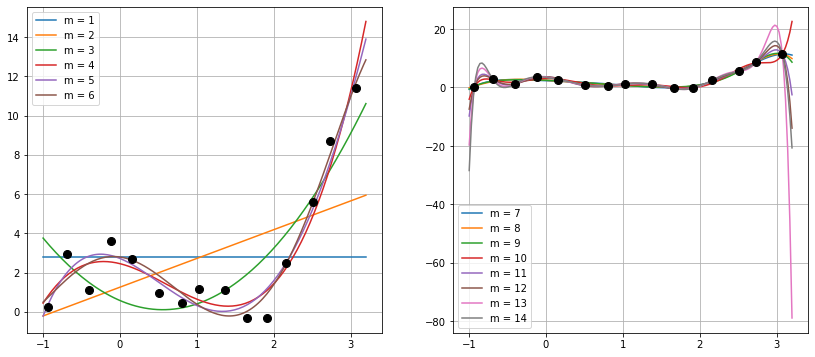

In [17]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

m_vals1 = range(1, 7)
m_vals2 = range(7, 15)

for m_vals, ax in zip([m_vals1, m_vals2],
                      [ax1, ax2]):
    for m in m_vals:
        p = lsq_poly(x, y, m)
        xx = np.linspace(-1, 3.2, 151)
        ax.plot(xx, p(xx), '-', label='m = %s' % m)
    ax.plot(x, y, 'o', ms=8, color='k')
    ax.legend(loc='best')
    ax.grid(True)

## III. Linear least squares using the QR factorization.
For the optimal value of  $m$  from the previous part, solve the LLS problem using the QR factorization, without ever forming the normal equations explicitly. For the linear algebra subproblem, you can use standard library functions (look up `scipy.linalg.solve_triangular`, `scipy.linalg.qr` etc) or your code from previous weeks.

Compare the results with the results of solving the normal system of equations.

In [28]:
def lsq_qr(x, y, m):
    """Solve the LSQ problem via the QR decomp of the design matrix.

    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The degree of the LSQ polynomial
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
    
    """
    A = design_matrix(x,m)
    Q,R = np.linalg.qr(A)
    m = np.linalg.matrix_rank(R)
    R1 = R[:m,:]
    f = (Q.T @ y)[:m]
    a=np.linalg.solve(R1,f)
    return np.polynomial.polynomial.Polynomial(a)

In [29]:
from numpy.testing import assert_allclose

for m in range(1, 10):
    assert_allclose(lsq_qr(x, y, m=m).coef,
                    lsq_poly(x, y, m=m).coef,
                    atol=1e-14)

In [ ]:
# This cell spot-tests several polynomials to make sure that they are worse than your ``best'' polynomial.

